# Imports

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

/home/svetlana.maslenkova/.conda/envs/nlp_project_env/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.11.0+cu102
Torchvision Version:  0.12.0+cu102


In [4]:
import os, sys

cwd = os.getcwd()
cwd

'/home/svetlana.maslenkova/Documents/nlp_project'

In [5]:
TRAIN_DATA_PATH = cwd + '/data/dreaddit-train.csv'
TEST_DATA_PATH = cwd + '/data/dreaddit-test.csv'
CORRECTED_LABELS_DATA_PATH = cwd + '/data/reddit-scraped.csv'

PRETRAINED_FSJ_EMB_UNFREEZE_MODEL_PATH = cwd + '/checkpoints/pretrained_FSJ_lstm_lr0.00005_emb_unfreeze.pt'

DREDDIT_FT_MODEL_PATH = cwd + '/checkpoints/full_ekman_ft_dreddit_ft.pt'

# best_model_ft = '/content/drive/MyDrive/MBZUAI/NLP702/project/checkpoints/best_model_ft.pt'

# Data preprocessing

In [6]:
train_data = pd.read_csv(TRAIN_DATA_PATH)
test_data = pd.read_csv(TEST_DATA_PATH)
data = train_data[['text', 'label']].copy()
test_data = test_data[['text', 'label']].copy()
print('shape of the train dataset: ', data.shape)
print('number of positve samples: ', data[data.label==1].shape[0])
print('number of negative samples: ', data[data.label==0].shape[0])
print('the ratio of neg to pos: ', np.round(data[data.label==0].shape[0]/data[data.label==1].shape[0], 2))
print('shape of the test dataset: ', test_data.shape)
data.head()

shape of the train dataset:  (2838, 2)
number of positve samples:  1488
number of negative samples:  1350
the ratio of neg to pos:  0.91
shape of the test dataset:  (715, 2)


,text,label
0,"He said he had not felt that way before, sugge...",1
1,"Hey there r/assistance, Not sure if this is th...",0
2,My mom then hit me with the newspaper and it s...,1
3,"until i met my new boyfriend, he is amazing, h...",1
4,October is Domestic Violence Awareness Month a...,1


In [7]:
data['WORD_COUNT'] = data['text'].apply(lambda x: len(x.split()))
max_len = np.max(data.WORD_COUNT.values)
print('max number of words: ', max_len)

max number of words:  310


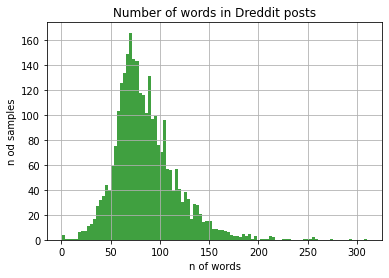

In [9]:
from matplotlib import pyplot as plt

plt.hist(data['WORD_COUNT'], 100, density=False, facecolor='g', alpha=0.75)

plt.xlabel('n of words')
plt.ylabel('n od samples')
plt.title('Number of words in Dreddit posts')
plt.grid(True)
plt.show()

In [8]:
data.head(2)

,text,label,WORD_COUNT
0,"He said he had not felt that way before, sugge...",1,113
1,"Hey there r/assistance, Not sure if this is th...",0,108


In [9]:
from torch.utils.data import Dataset, DataLoader

class Stress_FT_Dataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe['text']
        self.targets = self.data.label
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [10]:
from transformers import BertTokenizer
# Defining some key variables that will be used later on in the training
MAX_LEN = 200
EPOCHS = 50
LEARNING_RATE = 1e-05
num_classes = 2
batch_size = 100
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [11]:
from sklearn.model_selection import train_test_split

train_dataset, valid_dataset = train_test_split(data, random_state=42, test_size = 0.25)
valid_dataset = valid_dataset.reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)
test_dataset = test_data.reset_index(drop=True)


print("FULL Dataset: {}".format(data.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("VALID Dataset: {}".format(valid_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = Stress_FT_Dataset(train_dataset, tokenizer, MAX_LEN)
validation_set = Stress_FT_Dataset(valid_dataset, tokenizer, MAX_LEN)

train_loader = DataLoader(training_set, batch_size=batch_size , shuffle=True)
valid_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=True)

FULL Dataset: (2838, 3)
TRAIN Dataset: (2128, 3)
VALID Dataset: (710, 3)
TEST Dataset: (715, 2)


# Functions

In [12]:
import shutil, sys   
def save_ckp(state, is_best, checkpoint_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)

In [13]:
def loss_fn(outputs, targets):
    return torch.nn.CrossEntropyLoss()(outputs, targets)

In [14]:
def train_model(model, dataloaders, criterion, optimizer, checkpoint_path, num_epochs=15):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0
    # best_acc = 0.0
    wandb.watch(model)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)


        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = {'train':0.0, 'val':0.0}
            running_corrects = {'train':0, 'val':0}
            epoch_avg_loss = {'train':0.0, 'val':0.0}
            epoch_avg_acc = {'train':0.0, 'val':0.0}
            epoch_loss_list = {'train':[], 'val':[]}
            epoch_acc_list = {'train':[], 'val':[]}
            epoch_f1_list = {'train':[], 'val':[]}
            global_step = 0
            global_steps_list = []
            stacked_labels = torch.tensor([]).to(device=device)
            stacked_preds = torch.tensor([]).to(device=device)


            # Iterate over data.
            for batch_idx, data in enumerate(dataloaders[phase]):
                ids = data['ids'].to(device, dtype = torch.long)
                mask = data['mask'].to(device, dtype = torch.long)
                token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
                labels = data['targets'].to(device, dtype = torch.long)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # In train mode we calculate the loss by summing the final output
                    # and the auxiliary output but in testing we only consider the final output.
                    
                    outputs = model(ids, mask, token_type_ids)
                    loss = criterion(torch.sigmoid(outputs), labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        global_step += 1
                        wandb.log({'step_train_loss': loss.item(), 'global_step':global_step})

                    stacked_labels = torch.cat([stacked_labels, labels])
                    stacked_preds = torch.cat([stacked_preds, preds])

                    # statistics
                    running_loss[phase] += loss.item() # * labels.size(0)
                    running_corrects[phase] += torch.sum(preds == labels.data)
                    

            epoch_avg_loss[phase] = running_loss[phase] / len(dataloaders[phase].dataset)
            epoch_avg_acc[phase] = running_corrects[phase].double() / len(dataloaders[phase].dataset)
            epoch_f1 = f1_score(stacked_labels.cpu(), stacked_preds.cpu())
            epoch_loss_list[phase].append(epoch_avg_loss[phase])
            epoch_acc_list[phase].append(epoch_avg_acc[phase])
            epoch_f1_list[phase].append(epoch_f1)

            print('{} Loss: {:.4f} Acc: {:.4f} F1: {:.4f}'.format(phase, epoch_avg_loss[phase], epoch_avg_acc[phase], epoch_f1))
            
            # deep copy the model
            if phase == 'val' and epoch_f1 > best_f1:
                best_f1 = epoch_f1
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_avg_acc[phase])
                wandb.log({"epoch_avg_loss_val": epoch_avg_loss[phase], 'epoch_avg_acc_val':epoch_avg_acc[phase], "epoch_f1":epoch_f1, 'epoch':epoch+1})
            if phase == 'train':
                wandb.log({"epoch_avg_loss_train": epoch_avg_loss[phase], 'epoch_avg_acc_train':epoch_avg_acc[phase], 'epoch':epoch+1})
              
            running_loss[phase] = 0.0
            running_corrects[phase] = 0.0
        
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    # print('Best val Acc: {:4f}'.format(best_acc))
    print('Best val F1: {:4f}'.format(best_f1))

    # load best model weights
    model.load_state_dict(best_model_wts)

    checkpoint = {
            'epoch': epoch + 1,
            'valid_loss_min': epoch_avg_loss['val'],
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
      }

    # save checkpoint
    save_ckp(checkpoint, False, checkpoint_path)
    return model, val_acc_history

In [15]:
## model without LSRM layer
# class BERTClass(torch.nn.Module):
#     def __init__(self):
#         super(BERTClass, self).__init__()
#         self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased', return_dict=False)
#         self.l2 = torch.nn.Dropout(0.3)
#         self.l3 = torch.nn.Linear(768, 3)
    
#     def forward(self, ids, mask, token_type_ids):
#         _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
#         output_2 = self.l2(output_1)
#         output = self.l3(output_2)
#         return output

# baseline model
class BERTClass_Dreddit(torch.nn.Module):
    def __init__(self):
        super(BERTClass_Dreddit, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased', return_dict=False)
        self.l2 = torch.nn.Dropout(0.3)
        self.lstm = nn.LSTM(input_size=768,
                    hidden_size=128,
                    num_layers=1,
                    batch_first=True,
                    bidirectional=True)
        self.l3 = torch.nn.Linear(256, 2)
    
    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output = self.l2(output).unsqueeze(1)
        output, _ = self.lstm(output)
        output = self.l3(output).squeeze(1)
        return output

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased', return_dict=False)
        self.l2 = torch.nn.Dropout(0.3)
        self.lstm = nn.LSTM(input_size=768,
                            hidden_size=128,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        self.l3 = torch.nn.Linear(256, 3)
    
    def forward(self, ids, mask, token_type_ids):
        _, output= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output = self.l2(output).unsqueeze(1)
        output, _ = self.lstm(output)
        output = self.l3(output).squeeze(1)
        return output

model = BERTClass()

In [16]:
def initialize_model(pretrained_path, num_classes, use_pretrained=True, gpu=False):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    input_size = 0
    
    if gpu==True:
      map_location = torch.device('cuda')
    else:
      map_location = torch.device('cpu')
      
    model_ft = BERTClass()
    model_ft.load_state_dict(torch.load(pretrained_path, map_location=map_location)['state_dict'])
    num_ftrs = model_ft.l3.in_features
    model_ft.l3 = nn.Linear(num_ftrs, num_classes)

    return model_ft, input_size


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [19]:
# Initialize the model for this run
model_ft, input_size = initialize_model(PRETRAINED_FSJ_EMB_UNFREEZE_MODEL_PATH, num_classes, use_pretrained=True, gpu=False)
model_ft.to(device)
# Print the model we just instantiated
# print(model_ft)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    

In [ ]:
params_to_update = model_ft.parameters()

## print model parameters
# for name, param in model_ft.named_parameters():   
#     print("\t",name, param.requires_grad)

In [21]:
from torch.optim import Adam

optimizer_ft = Adam(params_to_update, lr= LEARNING_RATE)

In [22]:
dataloaders_dict = {}
dataloaders_dict['train'] = train_loader
dataloaders_dict['val'] = valid_loader

In [23]:
DREDDIT_FT_MODEL_PATH = '/home/svetlana.maslenkova/Documents/nlp_project/checkpoints/FT_FSJ_dreddit_ft_lr0.00005_emb_9_unfreeze.pt'

In [24]:
import wandb

#  Start a new run
wandb.init(project="nlp-project", name='FT_3_fullEkman_dreddit_ft_lr0.00005_emb_9_unfreeze')

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, loss_fn, optimizer_ft, num_epochs=50, checkpoint_path=DREDDIT_FT_MODEL_PATH)

wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: maslenkovas (use `wandb login --relogin` to force relogin)


Epoch 1/50
----------
train Loss: 0.0070 Acc: 0.6400 F1: 0.6924
val Loss: 0.0073 Acc: 0.7352 F1: 0.7679

Epoch 2/50
----------
train Loss: 0.0065 Acc: 0.8022 F1: 0.8138
val Loss: 0.0070 Acc: 0.7535 F1: 0.8000

Epoch 3/50
----------
train Loss: 0.0061 Acc: 0.8524 F1: 0.8632
val Loss: 0.0068 Acc: 0.7606 F1: 0.8005

Epoch 4/50
----------
train Loss: 0.0057 Acc: 0.8849 F1: 0.8924
val Loss: 0.0065 Acc: 0.7789 F1: 0.8151

Epoch 5/50
----------
train Loss: 0.0053 Acc: 0.9084 F1: 0.9145
val Loss: 0.0062 Acc: 0.7901 F1: 0.8198

Epoch 6/50
----------
train Loss: 0.0050 Acc: 0.9309 F1: 0.9354
val Loss: 0.0061 Acc: 0.8014 F1: 0.8253

Epoch 7/50
----------
train Loss: 0.0047 Acc: 0.9474 F1: 0.9506
val Loss: 0.0059 Acc: 0.7958 F1: 0.8221

Epoch 8/50
----------
train Loss: 0.0045 Acc: 0.9601 F1: 0.9622
val Loss: 0.0061 Acc: 0.7958 F1: 0.8194

Epoch 9/50
----------
train Loss: 0.0043 Acc: 0.9652 F1: 0.9671
val Loss: 0.0057 Acc: 0.8169 F1: 0.8354

Epoch 10/50
----------
train Loss: 0.0042 Acc: 0.9718 F

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch_avg_acc_train,▁▄▅▆▇▇▇█████████████████████████████████
epoch_avg_acc_val,▁▃▃▅▇▆▆█▇▆▆▇▇▇▇▆▇▇▇██▅██▇█▇▇▆▇▅██▇▇▇▇▇▇█
epoch_avg_loss_train,█▇▆▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch_avg_loss_val,█▇▆▅▃▃▃▂▂▂▂▂▃▂▂▂▂▂▂▂▂▄▂▁▂▂▁▂▂▂▄▂▂▂▂▃▂▁▁▂
epoch_f1,▁▄▄▆▇▇▆██▇▇▇▇▇▆▆▇▇▇██▆██▇█▇▇▇▇▆███████▇█
global_step,▆▄▇▃▁▅█▄▂▅▁▇▂▆▂▇▃▇▅█▄▇▅▁▅▂▆▂▅▃▇▂█▄▇▃▁▅█▄
step_train_loss,█▇▆▅▄▄▃▂▂▂▂▂▂▂▂▂▂▂▂▃▁▁▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▂▁▁
epoch,50
epoch_avg_acc_train,0.98637
epoch_avg_acc_val,0.81549


In [85]:
def load_checkpoint(load_path, model, optimizer):
  if load_path==None: return

  state_dict = torch.load(load_path, map_location=device)
  print(f'Model loaded from <== {load_path}')

  model.load_state_dict(state_dict['state_dict'])
  optimizer.load_state_dict(state_dict['optimizer'])

  return state_dict['valid_loss_min']


## Evaluation

In [25]:
from sklearn.metrics import classification_report

def evaluate(model, test_data, use_cuda=False):

    test = Stress_FT_Dataset(test_data, tokenizer, MAX_LEN)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=8)

    # use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda==True else "cpu")
    model = model.to(device)
    stacked_labels = torch.tensor([])
    stacked_preds = torch.tensor([])

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for batch_idx, data in enumerate(test_dataloader):

            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.int)

            output = model(ids, mask, token_type_ids)
            output = torch.sigmoid(output).cpu()
            preds = torch.tensor(np.array(output.detach().numpy()) > 0.5).to(device, dtype = torch.int)
            preds = preds.argmax(dim=1)
            acc = (preds == targets).sum().item()
            total_acc_test += acc
            stacked_labels = torch.cat([stacked_labels, targets])
            stacked_preds = torch.cat([stacked_preds, preds])
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    print(classification_report(stacked_labels, stacked_preds, output_dict=False))

    return classification_report(stacked_labels, stacked_preds, output_dict=True)
    

In [23]:
DREDDIT_FT_MODEL_PATH

'/home/svetlanamaslenkova/Documents/nlp_project/checkpoints/full_ekman_ft_dreddit_ft.pt'

In [115]:
load_checkpoint(DREDDIT_FT_MODEL_PATH, model_ft, optimizer_ft)

Model loaded from <== /home/svetlanamaslenkova/Documents/nlp_project/checkpoints/4cat_ft_dreddit_ft.pt


0.008365489542484283

In [26]:
device = 'cpu'
print(device)

cpu


In [27]:
model_ft = model_ft.to(device)

In [28]:
test_data = pd.read_csv(TEST_DATA_PATH)[['text', 'label']]

test_set = Stress_FT_Dataset(test_data, tokenizer, MAX_LEN)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=16)

In [29]:
evaluate(model_ft, test_data)

Test Accuracy:  0.779
              precision    recall  f1-score   support

         0.0       0.80      0.73      0.76       346
         1.0       0.76      0.83      0.79       369

    accuracy                           0.78       715
   macro avg       0.78      0.78      0.78       715
weighted avg       0.78      0.78      0.78       715



{'0.0': {'precision': 0.7974683544303798,
  'recall': 0.7283236994219653,
  'f1-score': 0.7613293051359517,
  'support': 346},
 '1.0': {'precision': 0.7644110275689223,
  'recall': 0.8265582655826558,
  'f1-score': 0.7942708333333333,
  'support': 369},
 'accuracy': 0.779020979020979,
 'macro avg': {'precision': 0.7809396909996511,
  'recall': 0.7774409825023105,
  'f1-score': 0.7778000692346425,
  'support': 715},
 'weighted avg': {'precision': 0.7804079997284529,
  'recall': 0.779020979020979,
  'f1-score': 0.7783298980098451,
  'support': 715}}